In [1]:
# Cell One: imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
sns.set_style('whitegrid')

print("Imports ok")

Imports ok


In [2]:
# Cell two: load and view CSV  
df = pd.read_csv('survey.csv')
print("Shape:", df.shape)
display(df.head(6))
display(df.info())

Shape: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
5,2014-08-27 11:31:22,33,Male,United States,TN,NaN,Yes,No,Sometimes,6-25,No,Yes,Yes,Not sure,No,Don't know,Don't know,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

None

In [3]:
# Show the 10 largest and smallest values from column 'Age'
print(df['Age'].sort_values(ascending=False).head(10))
print(df['Age'].sort_values(ascending=True).head(10))

390     99999999999
364             329
1182             72
560              65
520              62
952              61
1236             60
297              60
471              58
475              57
Name: Age, dtype: int64
715    -1726
143      -29
1127      -1
734        5
989        8
1090      11
118       18
93        18
287       18
43        18
Name: Age, dtype: int64


Columns: ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']

Target value counts (treatment):
treatment
Yes    637
No     622
Name: count, dtype: int64


comments          86.97
state             40.91
work_interfere    20.97
self_employed      1.43
dtype: float64

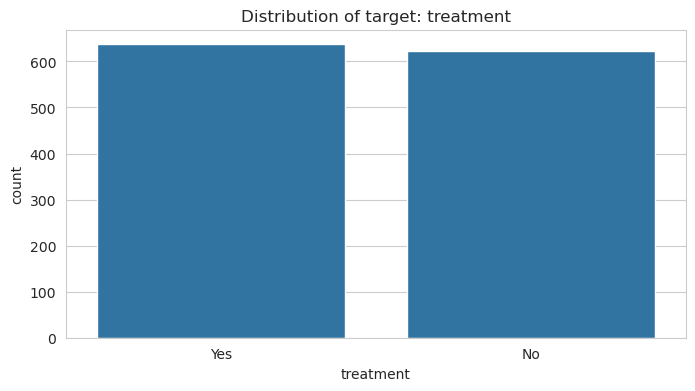

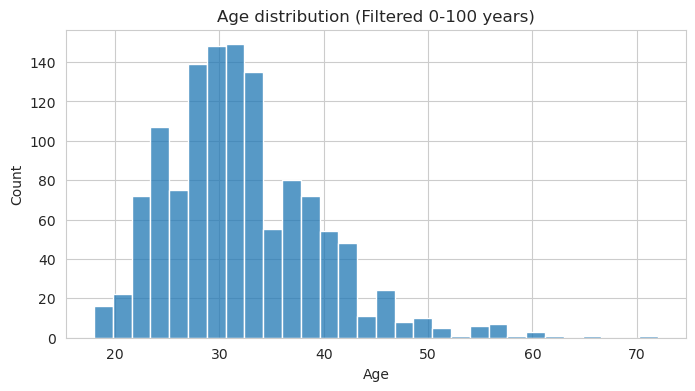

In [4]:
# Cell three:Exploratory Data Analysis
print("Columns:", list(df.columns))
print("\nTarget value counts (treatment):")
print(df['treatment'].value_counts(dropna=False))

# Missing values %
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
display(missing_pct[missing_pct>0].round(2))

# Visualization
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='treatment', order=df['treatment'].value_counts().index)
plt.title('Distribution of target: treatment')
plt.show()

# Age
plt.figure(figsize=(8,4))

# 1. Outliers removal
df2 = df[(df['Age'] >= 14) & (df['Age'] <= 100)].copy()

# 2. Usamos esse novo DataFrame para o gráfico
sns.histplot(df2['Age'].dropna(), bins=30)
plt.title('Age distribution (Filtered 0-100 years)')
plt.show()


In [5]:
# Normalize Gender: map to Male / Female / Other
def clean_gender(x):
    if pd.isna(x): return 'Other'
    s = str(x).strip().lower()
    # common cases
    if s in ['male', 'm', 'man', 'male-ish', 'maile', 'mal', 'cis male', 'male (cis)']: return 'Male'
    if s in ['female', 'f', 'woman', 'female (cis)', 'cis female']: return 'Female'
    # other
    return 'Other'

df2['Gender_clean'] = df2['Gender'].apply(clean_gender)

# Map binary answers from 'Yes'/'No' to 1/0 for columns that have them:
bin_cols = ['self_employed','family_history','treatment','remote_work','tech_company']
for c in bin_cols:
    if c in df2.columns:
        df2.loc[:, c] = df2[c].replace({'Yes':1, 'No':0})
print("Cleaned basic columns. Sample:")
display(df2[['Age','Gender','Gender_clean','self_employed','family_history','treatment']].head(30))

Cleaned basic columns. Sample:


/tmp/ipykernel_14894/494981540.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2.loc[:, c] = df2[c].replace({'Yes':1, 'No':0})


,Age,Gender,Gender_clean,self_employed,family_history,treatment
0,37,Female,Female,NaN,0,1
1,44,M,Male,NaN,0,0
2,32,Male,Male,NaN,0,0
3,31,Male,Male,NaN,1,1
4,31,Male,Male,NaN,0,0
5,33,Male,Male,NaN,1,0
6,35,Female,Female,NaN,1,1
7,39,M,Male,NaN,0,0
8,42,Female,Female,NaN,1,1
9,23,Male,Male,NaN,0,0


In [6]:
# Cell 5: Initial features and simple new features
df3 = df2.copy()

candidate_features = [
    'Age', 
    'Gender_clean',
    'self_employed',
    'family_history',
    'work_interfere',   # categorical: 'Never','Rarely','Sometimes','Often'
    'no_employees',     # categorical: size of company
    'remote_work',
    'tech_company',
    'benefits',
    'care_options',
    'wellness_program',
    'seek_help',
    'anonymity'
]

# See which columns exist in the df.
candidate_features = [c for c in candidate_features if c in df3.columns]
print("Candidate features used:", candidate_features)

# quick peek at categorical uniques for those columns
for c in candidate_features:
    if df3[c].dtype=='object' or df3[c].nunique() < 20:
        print(f"\n--- {c} unique values ---")
        print(df3[c].fillna('NA').value_counts().head(10))

Candidate features used: ['Age', 'Gender_clean', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity']

--- Gender_clean unique values ---
Gender_clean
Male      978
Female    244
Other      29
Name: count, dtype: int64

--- self_employed unique values ---
self_employed
0.0    1091
1.0     142
NA       18
Name: count, dtype: int64

--- family_history unique values ---
family_history
0    762
1    489
Name: count, dtype: int64

--- work_interfere unique values ---
work_interfere
Sometimes    464
NA           262
Never        212
Rarely       173
Often        140
Name: count, dtype: int64

--- no_employees unique values ---
no_employees
6-25              289
26-100            288
More than 1000    281
100-500           175
1-5               158
500-1000           60
Name: count, dtype: int64

--- remote_work unique values ---
remote_work
0    880
1    371
Name: count, d

/tmp/ipykernel_14894/2803924760.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(df3[c].fillna('NA').value_counts().head(10))
/tmp/ipykernel_14894/2803924760.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(df3[c].fillna('NA').value_counts().head(10))


In [7]:
# Cell 6: preprocessing pipeline: imputers, scaler e one-hot

num_features = [c for c in candidate_features if df3[c].dtype in ['int64','float64'] and c!='treatment']
cat_features = [c for c in candidate_features if c not in num_features]

print("num_features:", num_features)
print("cat_features:", cat_features)

# Numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
], remainder='drop', sparse_threshold=0)



num_features: ['Age']
cat_features: ['Gender_clean', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity']


In [9]:
# Cell 7: Prepare X,y and separate training/test (ROBUST VERSION)

X = df3[candidate_features].copy()

# --- CORRECTION IS HERE ---
# A lógica antiga estava a criar 100% de NaNs.
# Vamos usar a lógica "À Prova de Bala" que já descobrimos:

# 1. Primeiro, substitui o texto 'Yes'/'No' (se existir) por 1/0
y_temp = df3['treatment'].replace({'Yes': 1, 'No': 0})

# 2. DEPOIS, usa pd.to_numeric para forçar tudo o resto
#    Isto converte 1.0 -> 1.0, '1' -> 1.0, "Don't Know" -> NaN
y = pd.to_numeric(y_temp, errors='coerce')
# --- FIM DA CORREÇÃO ---


# Agora, removemos as poucas linhas que podem ter sido "Don't Know" (NaN)
mask = y.notna()
X = X[mask]
y = y[mask].astype(int) # .astype(int) agora funciona porque não há NaNs

print(f"Shape after cleaning NaNs from target: X={X.shape}, y={y.shape}")

# Isto agora vai funcionar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train/test shapes:", X_train.shape, X_test.shape)
print("Train target dist:", np.bincount(y_train)/len(y_train))

Shape after cleaning NaNs from target: X=(1251, 13), y=(1251,)
Train/test shapes: (1000, 13) (251, 13)
Train target dist: [0.495 0.505]


/tmp/ipykernel_14894/2785600200.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_temp = df3['treatment'].replace({'Yes': 1, 'No': 0})


In [11]:
# Cell 6 (CORRIGIDA): preprocessing pipeline
from sklearn.preprocessing import FunctionTransformer # <-- IMPORTAR ISTO

num_features = [c for c in candidate_features if df3[c].dtype in ['int64','float64'] and c!='treatment']
cat_features = [c for c in candidate_features if c not in num_features]

print("num_features:", num_features)
print("cat_features:", cat_features)

# Numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline (COM A CORREÇÃO)
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str))), # <-- A CORREÇÃO MÁGICA
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
], remainder='drop', sparse_threshold=0)

print("Preprocessor (com o fix .astype(str)) criado.")

num_features: ['Age']
cat_features: ['Gender_clean', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity']
Preprocessor (com o fix .astype(str)) criado.


In [12]:
# Cell 8.1: Confusion Matrix (Original Model)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Generate the matrix
# (y_test is the truth, y_pred is the prediction from your original model)
cm_original = confusion_matrix(y_test, y_pred)

# 2. Draw the matrix
disp_original = ConfusionMatrixDisplay(confusion_matrix=cm_original, 
                                       display_labels=['No', 'Yes'])

# 3. Show the plot
print("Confusion Matrix (Original Model - No Tuning):")
disp_original.plot(cmap=plt.cm.Blues, colorbar=False)
disp_original.ax_.grid(False) # Turn off the grid
plt.show()

NameError: name 'y_pred' is not defined

In [ ]:
# Cell 9: Imports and definition of the Tuning Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1. Create the COMPLETE pipeline
# Joins your 'preprocessor' (which you already have) with the 'LogisticRegression'
#
# Note: I'm adding solver='liblinear' and max_iter=1000
# 'liblinear' is good for small datasets and handles L1/L2 regularization well
# A higher 'max_iter' avoids annoying convergence warnings.

pipe_lr = Pipeline([
    ('pre', preprocessor), 
    ('model', LogisticRegression(solver='liblinear', max_iter=1000))
])

# 2. Define the "grid" of parameters we want to test
# We will test the regularization strength (C) and the regularization type (penalty)
#
# 'model__C' -> The '__' (double underscore) tells the Pipeline: 
# "I want you to pass the 'C' parameter to the step I called 'model'"

param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100] 
}

# 3. Configure the GridSearch
# cv=5 -> 5-fold cross-validation (as you had already done)
# scoring='f1' -> We want to optimize for the F1 score
# n_jobs=-1 -> Use all your PC's processors. It will be fast.
grid_lr = GridSearchCV(pipe_lr, param_grid, cv=5, scoring='f1', n_jobs=-1)

In [ ]:
# Cell 10: Run the Tuning
import time
start_time = time.time()

# Fit the GridSearch (this might take a few seconds)
# It will use X_train and y_train
grid_lr.fit(X_train, y_train)

end_time = time.time()

print(f"GridSearch took {end_time - start_time:.2f} seconds.")
print("---")
print(f"Best F1 score (in CV): {grid_lr.best_score_:.4f}")
print("Best parameters found:")
print(grid_lr.best_params_)

In [ ]:
# Cell 11: Evaluate the optimized model on the test set
from sklearn.metrics import classification_report

# Get the best estimator that GridSearch found
best_lr = grid_lr.best_estimator_

# Make predictions on X_test
y_pred_lr_tuned = best_lr.predict(X_test)

print("Classification Report (Optimized Model on Test Set):")
print(classification_report(y_test, y_pred_lr_tuned))

In [ ]:
# Cell 12: Feature Importance Analysis
import pandas as pd

# 1. Get the trained model (it's inside the pipeline)
model = best_lr.named_steps['model']

# 2. Get the preprocessor (so we know the column names)
preprocessor = best_lr.named_steps['pre']

# 3. Get the feature names
# The preprocessor has 2 transformers ('num' and 'cat')
# The 'cat' transformer has the 'onehot' encoder inside it
onehot_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features)

# Join the numeric + one-hot feature names
# (The order MUST be the same as in ColumnTransformer: num, then cat)
all_features = num_features + list(onehot_features)

# 4. Create a nice DataFrame to see the results
coefs = model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefs, # 'Coeficiente' translated
    'Abs_Coef': abs(coefs) # Absolute value to sort by importance
})

# 5. Show the 10 most impactful features (positive or negative)
print("Most important features (total impact):")
display(feature_importance.sort_values(by='Abs_Coef', ascending=False).head(10))

# 6. Show the top 5 features that lead to "Yes" (treatment=1)
print("\nFeatures that most indicate 'Treatment = Yes':")
display(feature_importance.sort_values(by='Coefficient', ascending=False).head(5))

# 7. Show the top 5 features that lead to "No" (treatment=0)
print("\nFeatures that most indicate 'Treatment = No':")
display(feature_importance.sort_values(by='Coefficient', ascending=True).head(5))

In [ ]:
# Cell 13: Confusion Matrix (Clean Version)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Generate the matrix (this stays the same)
cm = confusion_matrix(y_test, y_pred_lr_tuned)

# 2. Draw the matrix (this stays the same)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['No', 'Yes'])

# 3. Show the plot
print("Confusion Matrix (Optimized Model):")

#  Add 'colorbar=False' to remove the scale on the right
disp.plot(cmap=plt.cm.Blues, colorbar=False) 

# The plot's 'axis' (ax_) and turn off the grid
disp.ax_.grid(False)

plt.show()

In [ ]:
# Cell 14: ROC Curve (Receiver Operating Characteristic)
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# 1. First, let's create the "canvas" (the axis)
# This allows us to draw both lines on the same plot
fig, ax = plt.subplots()

# 2. Now, we tell RocCurveDisplay to draw itself ON THAT canvas
# It uses .predict_proba() automatically to get the "confidence"
RocCurveDisplay.from_estimator(
    best_lr, # Your tuned model from GridSearch
    X_test,
    y_test,
    name='Logistic Regression (Tuned)', # Name for the legend
    ax=ax # Tells it to use the canvas we created
)

# 3. Finally, we draw the "chance" (Dummy) line on the SAME canvas
ax.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)') # 'k--' is a black dashed line
    
# 4. Clean up and show
ax.set_title('ROC Curve (Optimized Model)')
ax.legend() # Activates the legend (which shows your model's AUC)
plt.show()

# 5. (Optional) Print the AUC score separately
# The plot already shows it, but this way you have the number
y_probs = best_lr.predict_proba(X_test)[:, 1] # Probabilities for the "Yes" class only
auc_score = roc_auc_score(y_test, y_probs)
print(f"Area Under the Curve (AUC Score): {auc_score:.4f}")